# 진행 배경
- start_hour, accident_hour, duration 세 개를 비교했을 때 앞뒤가 맞지 않는 경우가 존재
- 예를 들면, 15시에 빌렸고 대여기간은 2시간인데 사고가 21시 이후 발생하는 경우
- 해당 경우들을 찾아낸 후, 전처리 시 삭제할 예정 (train데이터만! test는 안건드림)

# 0. 작업 전 데이터 전처리

In [1]:
# 데이터 불러오고 카피 생성
df_raw = pd.read_csv('datas/insurance_fraud_detect_data(0408).csv')
df = df_raw.copy()

In [2]:
# 헷갈리니 start_hour, duration, accident_hour 순서 순으로 다시 범주화
# start_hour
df["start_hour"].replace(2, 10, inplace=True) # 1은 21~04시 (변동X)
df["start_hour"].replace(3, 2, inplace=True) # 2는 05~07시
df["start_hour"].replace(4, 3, inplace=True) # 3은 8~10시
df["start_hour"].replace(5, 4, inplace=True) # 4는 11~13시
df["start_hour"].replace(6, 5, inplace=True) # 5는 14~16시
df["start_hour"].replace(10, 6, inplace=True) # 6은 17~20시


# accident_hour
df["accident_hour"].replace(2, 10, inplace=True) # 1은 21~04시 (변동X)
df["accident_hour"].replace(3, 2, inplace=True) # 2는 05~07시
df["accident_hour"].replace(4, 3, inplace=True) # 3은 8~10시
df["accident_hour"].replace(5, 4, inplace=True) # 4는 11~13시
df["accident_hour"].replace(6, 5, inplace=True) # 5는 14~16시
df["accident_hour"].replace(10, 6, inplace=True) # 6은 17~20시


# duration
df["duration"].replace(5, 10, inplace=True) # 1은 0~1시간대
df["duration"].replace(4, 5, inplace=True) # 2는 2~5시간대
df["duration"].replace(3, 4, inplace=True) # 3은 6~9시간대
df["duration"].replace(2, 3, inplace=True) # 4는 10~36시간대
df["duration"].replace(1, 2, inplace=True) # 5는 36시간 초과
df["duration"].replace(10, 1, inplace=True)

In [27]:
# 사기 데이터와 그렇지 않은 데이터 구분
df_yes = df[df["fraud_YN"]==1]
df_no = df[df["fraud_YN"]==0]

In [28]:
# duration이 3미만 (10시간 이하)인 데이터들만 필터링
df_yes_dur123 = df_yes[df_yes.duration <= 3]
df_no_dur123 = df_no[df_no.duration <= 3]

In [29]:
# start_hour와 accident_hour 차이를 나타내는 gap열 생성
df_yes_dur123["gap_start_acci"] = df_yes_dur123["accident_hour"] - df_yes_dur123["start_hour"]
df_no_dur123["gap_start_acci"] = df_no_dur123["accident_hour"] - df_no_dur123["start_hour"]

/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [30]:
# gap의 고유값들 확인
print("Normal: ", sorted(df_no_dur123.gap_start_acci.unique()))
print("Fraud: ", sorted(df_yes_dur123.gap_start_acci.unique()))

Normal:  [-7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
Fraud:  [-5, 0, 1, 2]


In [31]:
# 확인 전, 편의상 start_hour, accident_hour, gap_start_acci, duration 열만 추출
df_yes_dur123 = df_yes_dur123[["start_hour", "accident_hour", "gap_start_acci", "duration", "test_set"]]
df_no_dur123 = df_no_dur123[["start_hour", "accident_hour", "gap_start_acci", "duration", "test_set"]]

In [32]:
# fraud 데이터 중 시간 갭이 -5인 데이터 확인
df_yes_dur123[df_yes_dur123["gap_start_acci"]==-5]

,start_hour,accident_hour,gap_start_acci,duration,test_set
143,6,1,-5,2,0


In [33]:
# 일자가 넘어갔기 때문이며, 사실상 gap은 1이므로 값 대치
df_yes_dur123["gap_start_acci"].replace(-5, 1, inplace=True)
df_yes_dur123[df_yes_dur123["gap_start_acci"]==-5]

,start_hour,accident_hour,gap_start_acci,duration,test_set


# 1. 사기 데이터 확인 

In [34]:
# 확인결과, 사기데이터 17건에는 이상 없음
df_yes_dur123

,start_hour,accident_hour,gap_start_acci,duration,test_set
18,1,1,0,3,0
83,5,6,1,3,0
100,3,3,0,3,1
143,6,1,1,2,0
163,4,4,0,3,0
230,3,3,0,2,0
364,3,4,1,2,0
383,6,6,0,3,0
417,5,5,0,2,0
436,3,3,0,2,0


In [43]:
# 이제, 정상데이터 중 train데이터만 골라내서, 지워야 할 인덱스들을 뽑아낼 것
# 먼저 지울 인덱스 리스트부터 만들고, gap이 어떻게 나왔나 보자 -> 다양하네..
list_for_del = []
sorted(df_no_dur123.gap_start_acci.unique())

[-7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]

# 2. 정상 데이터 확인

## 1) gap<0인 경우

In [37]:
# 우선 gap<0인 경우부터 보자 -> accident_hour==1이 절대다수다
np.unique(df_no_dur123[df_no_dur123["gap_start_acci"]<0]["accident_hour"],
         return_counts=True)

(array([-1,  1,  2,  3,  4,  5]), array([  17, 1130,    6,    9,    3,    8]))

/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


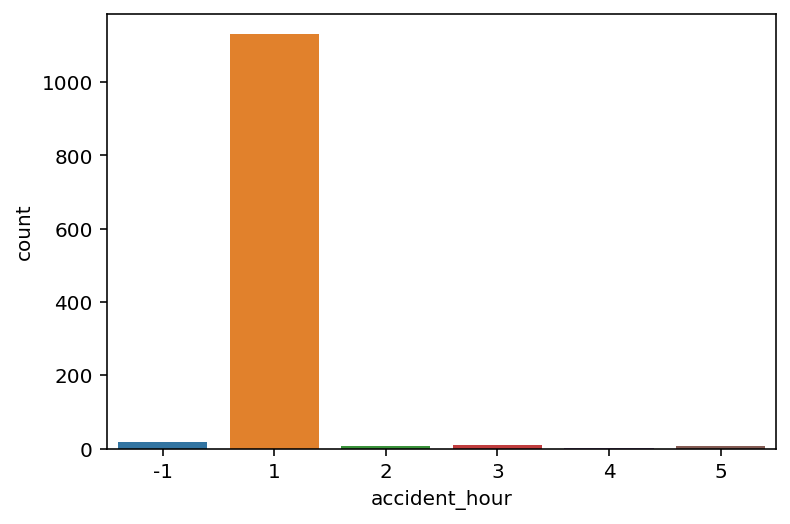

In [141]:
# 1이 절대다수인 거 다시 확인
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(df_no_dur123[df_no_dur123["gap_start_acci"]<0]["accident_hour"]);

### 일단 절대다수인 accident_hour==1 애들만 봐보자

In [38]:
# 사고시각 1인 애들만 봐보자 -> start_hour 기준 데이터 수가 6>5>4>3>2 순이다. 차례대로 보자..
np.unique(df_no_dur123[df_no_dur123["gap_start_acci"]<0]\
[df_no_dur123["accident_hour"]==1]["start_hour"], return_counts=True)

/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


(array([2, 3, 4, 5, 6]), array([  4,  16,  28, 177, 905]))

### (1) start_hour==6

In [41]:
# 6부터 -> 6에서 1은 사실 갭이 1로, 모든 duration에 대해 가능 -> 문제없음
df_no_dur123[df_no_dur123["gap_start_acci"]<0]\
[df_no_dur123["accident_hour"]==1][df_no_dur123["start_hour"]==6]\

/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,start_hour,accident_hour,gap_start_acci,duration,test_set
24,6,1,-5,3,0
38,6,1,-5,2,0
41,6,1,-5,2,0
54,6,1,-5,2,1
55,6,1,-5,3,1
...,...,...,...,...,...
15861,6,1,-5,2,1
15870,6,1,-5,3,0
15917,6,1,-5,2,0
15931,6,1,-5,2,1


### (2) start_hour==5

In [45]:
# 5 -> duration이 1이면 말이 안됨 -> 1가지 경우 존재
# 하지만 test 데이터라 지우지는 못함ㅠㅠ
df_no_dur123[df_no_dur123["gap_start_acci"]<0]\
[df_no_dur123["accident_hour"]==1][df_no_dur123["start_hour"]==5]\
[df_no_dur123["duration"]==1]

/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


,start_hour,accident_hour,gap_start_acci,duration,test_set
9837,5,1,-4,1,1


### (3) start_hour==4

In [52]:
# 4 -> 최소 8시간차로, duration이 1,2이면 말이 안됨
# test 데이터 아닌 경우 6개 존재 -> list_del 리스트에 추가

tmp = df_no_dur123[df_no_dur123["gap_start_acci"]<0]\
[df_no_dur123["accident_hour"]==1][df_no_dur123["start_hour"]==4]\
[df_no_dur123["duration"].isin([1,2])]

list_for_del.extend(tmp[tmp["test_set"]==0].index)
tmp

/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,start_hour,accident_hour,gap_start_acci,duration,test_set
43,4,1,-3,2,0
1504,4,1,-3,1,0
1762,4,1,-3,2,0
1766,4,1,-3,2,1
11706,4,1,-3,2,0
12031,4,1,-3,2,0
12665,4,1,-3,2,0


### (4) start_hour==3

In [58]:
# 3 -> 최소 11시간차로, 여기부터는 duration이 1,2,3으로 커버 안됨
# test 데이터 아닌 경우 14개 존재 -> list_del 리스트에 추가

tmp = df_no_dur123[df_no_dur123["gap_start_acci"]<0]\
[df_no_dur123["accident_hour"]==1][df_no_dur123["start_hour"]==3]

list_for_del.extend(tmp[tmp["test_set"]==0].index)
tmp

/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


,start_hour,accident_hour,gap_start_acci,duration,test_set
480,3,1,-2,2,0
4515,3,1,-2,2,0
4651,3,1,-2,2,0
5921,3,1,-2,2,1
8596,3,1,-2,3,0
9904,3,1,-2,3,0
10635,3,1,-2,3,0
11104,3,1,-2,2,0
11120,3,1,-2,1,0
11420,3,1,-2,2,1


### (5) start_hour==2

In [62]:
# 2 -> 최소 14시간차로, 여기부터는 duration이 1,2,3으로 커버 안됨
# test 데이터 아닌 경우 3개 존재 -> list_del 리스트에 추가

tmp = df_no_dur123[df_no_dur123["gap_start_acci"]<0]\
[df_no_dur123["accident_hour"]==1][df_no_dur123["start_hour"]==2]

list_for_del.extend(tmp[tmp["test_set"]==0].index)
tmp

/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


,start_hour,accident_hour,gap_start_acci,duration,test_set
209,2,1,-1,2,0
268,2,1,-1,2,0
4782,2,1,-1,3,1
12132,2,1,-1,2,0


## 2) gap>0인 경우

In [67]:
# 이제 gap>0인 경우도 보자 ->  (갭이 0은 오류가 없을 것이고, null값 처리는 여기서는 고려하지 않음)
np.unique(df_no_dur123[df_no_dur123["gap_start_acci"]>0]["accident_hour"],
         return_counts=True)

(array([2, 3, 4, 5, 6]), array([  99,  110,  702, 1465, 1637]))

### accident_hour=2,3,4,5,6에 대해서 차례대로 해보자..

### **** accident_hour=6 ****

In [74]:
sorted(df_no_dur123[df_no_dur123["gap_start_acci"]>0]\
[df_no_dur123["accident_hour"]==6]["start_hour"].unique())

/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


[1, 2, 3, 4, 5]

### (1) start_hour==5

In [75]:
# start_hour == 5 -> 문제없음
df_no_dur123[df_no_dur123["gap_start_acci"]>0]\
[df_no_dur123["accident_hour"]==6][df_no_dur123["start_hour"]==5]


/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,start_hour,accident_hour,gap_start_acci,duration,test_set
84,5,6,1,2,0
85,5,6,1,2,0
97,5,6,1,2,1
104,5,6,1,3,0
118,5,6,1,2,1
...,...,...,...,...,...
15966,5,6,1,3,1
15972,5,6,1,3,0
15976,5,6,1,2,0
15984,5,6,1,3,1


### (2) start_hour==4

In [82]:
# start_hour == 4 -> dur==1이면 안됨 -> 해당 경우 없음
df_no_dur123[df_no_dur123["gap_start_acci"]>0]\
[df_no_dur123["accident_hour"]==6][df_no_dur123["start_hour"]==4].duration.unique()


/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


array([3, 2])

### (3) start_hour==3

In [105]:
# start_hour == 3 -> dur==1,2이면 안됨 -> 2개 제거리스트 추가
tmp = df_no_dur123[df_no_dur123["gap_start_acci"]>0]\
[df_no_dur123["accident_hour"]==6][df_no_dur123["start_hour"]==3]\
[df_no_dur123["duration"].isin([1,2])]

list_for_del.extend(tmp[tmp["test_set"]==0].index)
tmp

/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


,start_hour,accident_hour,gap_start_acci,duration,test_set
8477,3,6,3,2,0
12705,3,6,3,2,0


### (4) start_hour==2

In [106]:
# start_hour == 2 -> dur==1,2,3은 안됨 -> 1개 제거리스트에 추가
tmp = df_no_dur123[df_no_dur123["gap_start_acci"]>0]\
[df_no_dur123["accident_hour"]==6][df_no_dur123["start_hour"]==2]

list_for_del.extend(tmp[tmp["test_set"]==0].index)
tmp

/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,start_hour,accident_hour,gap_start_acci,duration,test_set
8514,2,6,4,3,0


### (5) start_hour==1

In [90]:
# start_hour == 1 -> dur==1,2,3이면 안됨 -> 4개 제거리스트에 추가
tmp = df_no_dur123[df_no_dur123["gap_start_acci"]>0]\
[df_no_dur123["accident_hour"]==6][df_no_dur123["start_hour"]==1]

list_for_del.extend(tmp[tmp["test_set"]==0].index)
tmp

/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,start_hour,accident_hour,gap_start_acci,duration,test_set
532,1,6,5,1,0
4158,1,6,5,3,0
5401,1,6,5,2,0
13077,1,6,5,3,0


### **** accident_hour=5 ****

In [144]:
sorted(df_no_dur123[df_no_dur123["gap_start_acci"]>0]\
[df_no_dur123["accident_hour"]==5]["start_hour"].unique())

/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


[1, 2, 3, 4]

### (1) start_hour==4

In [94]:
# start_hour == 4 -> 문제없음
df_no_dur123[df_no_dur123["gap_start_acci"]>0]\
[df_no_dur123["accident_hour"]==5][df_no_dur123["start_hour"]==4]

/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,start_hour,accident_hour,gap_start_acci,duration,test_set
56,4,5,1,2,1
80,4,5,1,2,0
90,4,5,1,2,0
105,4,5,1,2,0
129,4,5,1,3,0
...,...,...,...,...,...
15955,4,5,1,2,1
15965,4,5,1,1,0
15978,4,5,1,2,1
15993,4,5,1,2,0


### (2) start_hour==3

In [96]:
# start_hour == 3 -> dur==1이면 안됨 -> 해당 경우 없음
df_no_dur123[df_no_dur123["gap_start_acci"]>0]\
[df_no_dur123["accident_hour"]==5][df_no_dur123["start_hour"]==3].duration.unique()

/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


array([3, 2])

### (3) start_hour==2

In [111]:
# start_hour == 2 -> dur==1,2는 안됨 -> 해당 경우 없음
df_no_dur123[df_no_dur123["gap_start_acci"]>0]\
[df_no_dur123["accident_hour"]==5][df_no_dur123["start_hour"]==2].duration.unique()



/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


array([3])

### (4) start_hour==1

In [113]:
# start_hour == 1 -> dur==1,2,3는 안됨 -> 5개 삭제
tmp = df_no_dur123[df_no_dur123["gap_start_acci"]>0]\
[df_no_dur123["accident_hour"]==5][df_no_dur123["start_hour"]==1]

list_for_del.extend(tmp[tmp["test_set"]==0].index)
tmp

/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,start_hour,accident_hour,gap_start_acci,duration,test_set
4595,1,5,4,2,0
6839,1,5,4,1,0
11710,1,5,4,1,0
12377,1,5,4,2,0
15080,1,5,4,2,0


### **** accident_hour=4 ****

In [116]:
# start_hour는 3가지 경우
sorted(df_no_dur123[df_no_dur123["gap_start_acci"]>0]\
[df_no_dur123["accident_hour"]==4]["start_hour"].unique())

/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


[1, 2, 3]

### (1) start_hour==3

In [117]:
# start_hour == 3 -> 문제없음
df_no_dur123[df_no_dur123["gap_start_acci"]>0]\
[df_no_dur123["accident_hour"]==4][df_no_dur123["start_hour"]==3]

/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,start_hour,accident_hour,gap_start_acci,duration,test_set
30,3,4,1,3,0
124,3,4,1,3,0
125,3,4,1,1,0
139,3,4,1,2,0
151,3,4,1,2,0
...,...,...,...,...,...
15961,3,4,1,3,0
15969,3,4,1,2,1
15971,3,4,1,2,1
15973,3,4,1,2,0


### (2) start_hour==2

In [123]:
# start_hour == 2 -> dur==1은 안됨 -> 이상없음
df_no_dur123[df_no_dur123["gap_start_acci"]>0]\
[df_no_dur123["accident_hour"]==4][df_no_dur123["start_hour"]==2].duration.unique()

/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


array([3, 2])

### (3) start_hour==1

In [128]:
# start_hour == 1 -> dur==1,2는 안됨 -> 6개 삭제 리스트 추가
tmp = df_no_dur123[df_no_dur123["gap_start_acci"]>0]\
[df_no_dur123["accident_hour"]==4][df_no_dur123["start_hour"]==1]\
[df_no_dur123["duration"].isin([1,2])]

list_for_del.extend(tmp[tmp["test_set"]==0].index)
tmp

/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


,start_hour,accident_hour,gap_start_acci,duration,test_set
1115,1,4,3,2,0
5398,1,4,3,2,0
5790,1,4,3,2,0
9523,1,4,3,1,0
9528,1,4,3,2,0
12050,1,4,3,1,0


### **** accident_hour=3 ****

In [131]:
# start_hour는 2가지 경우
sorted(df_no_dur123[df_no_dur123["gap_start_acci"]>0]\
[df_no_dur123["accident_hour"]==3]["start_hour"].unique())

/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


[1, 2]

### (1) start_hour==2

In [133]:
# start_hour == 2 -> 문제없음
df_no_dur123[df_no_dur123["gap_start_acci"]>0]\
[df_no_dur123["accident_hour"]==3][df_no_dur123["start_hour"]==2]

/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,start_hour,accident_hour,gap_start_acci,duration,test_set
169,2,3,1,3,0
239,2,3,1,2,0
335,2,3,1,3,0
566,2,3,1,3,1
593,2,3,1,3,0
...,...,...,...,...,...
15416,2,3,1,2,0
15499,2,3,1,2,1
15675,2,3,1,3,0
15710,2,3,1,3,0


### (2) start_hour==1

In [135]:
# start_hour == 1 -> dur==1은 안됨 -> 이상없음
df_no_dur123[df_no_dur123["gap_start_acci"]>0]\
[df_no_dur123["accident_hour"]==3][df_no_dur123["start_hour"]==1].duration.unique()

/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


array([2, 3])

### **** accident_hour=2 ****

In [137]:
# start_hour는 1가지 경우이며, 이 때 두 범주는 인접하므로 문제 가능성 없음
sorted(df_no_dur123[df_no_dur123["gap_start_acci"]>0]\
[df_no_dur123["accident_hour"]==2]["start_hour"].unique())

/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


[1]

## 총 제거대상은 ** 41개 ** rows

In [155]:
# 총 제거대상은 41개 rows (혹시 몰라 중복제거도 실시)
len(set(list_for_del))

41